In [1]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
from LowLevelModules.PyAPT import APTMotor
from scipy.optimize import curve_fit

def pol_fit_func(xx, a0, c0, x0):
    return a0 * np.cos(2*np.pi/180 * (xx-x0)) + c0

In [2]:
from LowLevelModules.NIdaqAPD import APDCounter
from LowLevelModules.GeneralFunctions import *

import time
import ipywidgets as widgets
from IPython.display import display

# initialize the HWP motors
hwp = {}
hwp['Emission'] = APTMotor(83853557, HWTYPE=31)
hwp['Emission'].setVelocityParameters(0, 25, 25)
print("HWP in emission ready to use")
hwp['Absorption'] = APTMotor(83857433, HWTYPE=31)
hwp['Absorption'].setVelocityParameters(0, 25, 25)
hwp['Absorption'].mAbs(0)
print("HWP in absorption ready to use and initialized to zero")
#calibration 3/7/19. Collection polarizer GL10 offset by 21.5 degrees, no pellicule in path
#calibration 3/22/19. Collection polarizer Lin Pol offset by 67 degrees, no pellicule in path
offset_col = -5.8

HWP in emission ready to use
HWP in absorption ready to use and initialized to zero


In [3]:
# make some checkboxes for easy selection of different parameters
savedata_choice = widgets.Checkbox(value=False, description='Save data')
fitdata_choice = widgets.Checkbox(value=True, description='Sine fit data')
mode_choice = widgets.RadioButtons(options=['Absorption', 'Emission'], value='Emission', description='HWP choice')
display(savedata_choice)
display(fitdata_choice)
display(mode_choice)

Checkbox(value=False, description='Save data')

Checkbox(value=True, description='Sine fit data')

RadioButtons(description='HWP choice', index=1, options=('Absorption', 'Emission'), value='Emission')

# Move HWP to a given position

In [14]:
go_to_position = 53
offset = offset_col if mode_choice.value == 'Emission' else 0
hwp[mode_choice.value].mAbs((go_to_position+offset)/2)
pos_current = 2 * hwp[mode_choice.value].getPos()
print('Current position of %s waveplate: %f' % (mode_choice.value, pos_current))
excitation_offset = hwp['Absorption'].getPos() * 2
excitation_offset

Current position of Absorption waveplate: 52.997375


52.9984130859375

# Run a polarization scan

-5.8


<IPython.core.display.Javascript object>


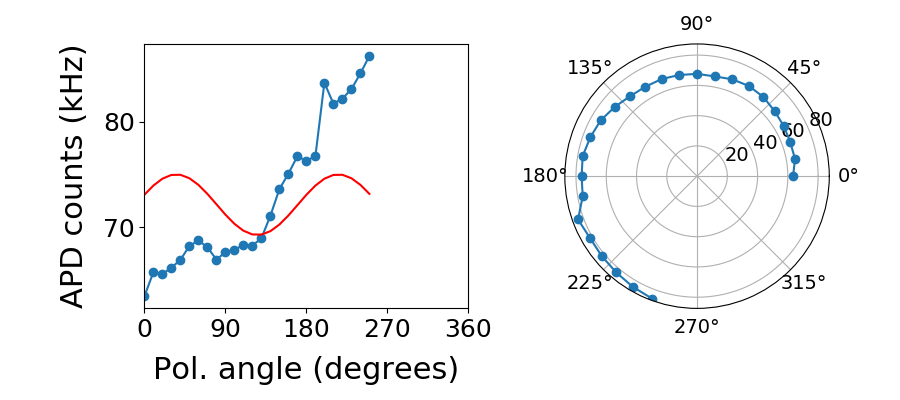

Polarization max:  35.48 degrees    and       215.48  degrees


In [16]:
"""#######################################   Default parameters   #########################################"""
terminal = "/Dev1/PFI5"   # APD that has the HWP and polarizer in front
ang_step = 10
collection_time = 1   #seconds
"""#########################################################################################################"""
offset = offset_col if mode_choice.value == 'Emission' else 0
print(offset)
lp = LivePlot(2, 1, 9, 4, 'o', 'Pol. angle (degrees)', 'APD counts (kHz)')

pos, cts = [], []
for p in np.arange(0, 370, ang_step):
    try:
        # move HWP to new position
        hwp[mode_choice.value].mAbs((p+offset)/2)
        # collect the APD count rate
        APD1 = APDCounter(terminal, task_name='Pol counts')
        APD1.start()
        time.sleep(collection_time)
        APD_cts = APD1.read() / collection_time / 1000
        APD1.close()
        # get the new data and update the plot
        pos.append(p)
        cts.append(APD_cts)
        lp.plot_live(pos, cts)
    except KeyboardInterrupt:
        # press the stop button to trigger this
        APD1.close()
        break

lp.ax1.set_xlim([0, 360])
lp.ax1.set_xticks(np.arange(0,370,90))

if fitdata_choice:
    data_x = np.array(pos)
    data_y = np.array(cts)
    # guess fit parameters
    guess_mean = np.mean(data_y)
    guess_std = 3*np.std(data_y)/(2**0.5)/(2**0.5)
    coeffs, _ = curve_fit(pol_fit_func, data_x, data_y, p0=[guess_std, guess_mean, 0])
    y_fit = pol_fit_func(data_x, *coeffs)
    lp.ax1.plot(data_x, y_fit, 'r-')
    pol_max = np.round(coeffs[2],2)
    print('Polarization max: ', pol_max, 'degrees    and      ', pol_max + 180, ' degrees' )
    
if savedata_choice.value:
    data_type = 'PLvsTheta'
    data_header = "%s HWP angle (degrees)     APD counts (kHz)" % (mode_choice.value,)
    data_array = np.array([pos, cts]).T
    data_save(data_array, lp.fig, data_type, data_header)

# Run this to shut down the connection with the drivers

In [59]:
hwp['Absorption'].cleanUpAPT()
hwp['Emission'].cleanUpAPT()

104.72289540126171 124.75458240760746 0.19573673688099286
Polarization max:  0.2 degrees    and       180.2  degrees
